In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys
import calendar as cal

In [2]:
#seasons = ['Annual','DJF','MAM','JJA','SON']
root_data_path = '/data/mmenegoz/daily/' # local, first test for only one year
save_data = '/data/mmenegoz/use_case_cci_snow'

In [3]:
%%time
# First test over the Alps for one year
first_year=1982
last_year=2018
period = slice(str(first_year)+'-01-01',str(last_year)+'-12-31')
# Alpine domain
latlim_ext,lonlim_ext=slice(43,48), slice(5,17)
# the data is extracted only the first time
from pathlib import Path
path = Path(save_data+'/Alpine_snow.nc')
if path.is_file():
    print(f'The file {path} already exists')
    ds_alps = xr.open_mfdataset(save_data+'/Alpine_snow.nc', parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    print(f'The file {path} does not exist')
    print(f'Extracting the data')
    # Parallelization?
    ds = xr.open_mfdataset(root_data_path+'*/*.nc', parallel=True)#, chunks={'time': -1, 'lat': 3600, 'lon': 7200})
    ds_alps=ds.sel(lat=latlim_ext, lon=lonlim_ext,time=period)
    ds_alps.to_netcdf(save_data+'/Alpine_snow.nc')

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow.nc does not exist
Extracting the data
CPU times: user 2h 14min 26s, sys: 55.7 s, total: 2h 15min 22s
Wall time: 2h 23min 19s


In [4]:
ds_alps

,Array,Chunk
Bytes,2.58 GB,5.95 MB
Shape,"(13422, 100, 240)","(31, 100, 240)"
Count,1764 Tasks,441 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,2.58 GB,5.95 MB
Shape,"(13422, 100, 240)","(31, 100, 240)"
Count,2205 Tasks,441 Chunks
Type,int64,numpy.ndarray
,Array,Chunk


In [5]:
time_extract='2001-03-01'
ds_alps_check=ds_alps.sel(time=time_extract)

Topography

In [6]:
ds_topo = xr.open_dataset('/data/mmenegoz/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds_topo.elevation
elevation_std = ds_topo.elevation_stddev

Plot

In [7]:
cmap='Blues'
cmap_cov='Reds'
levels=plot.arange(0,100,10)
levels_coverage=plot.arange(0,31,1)

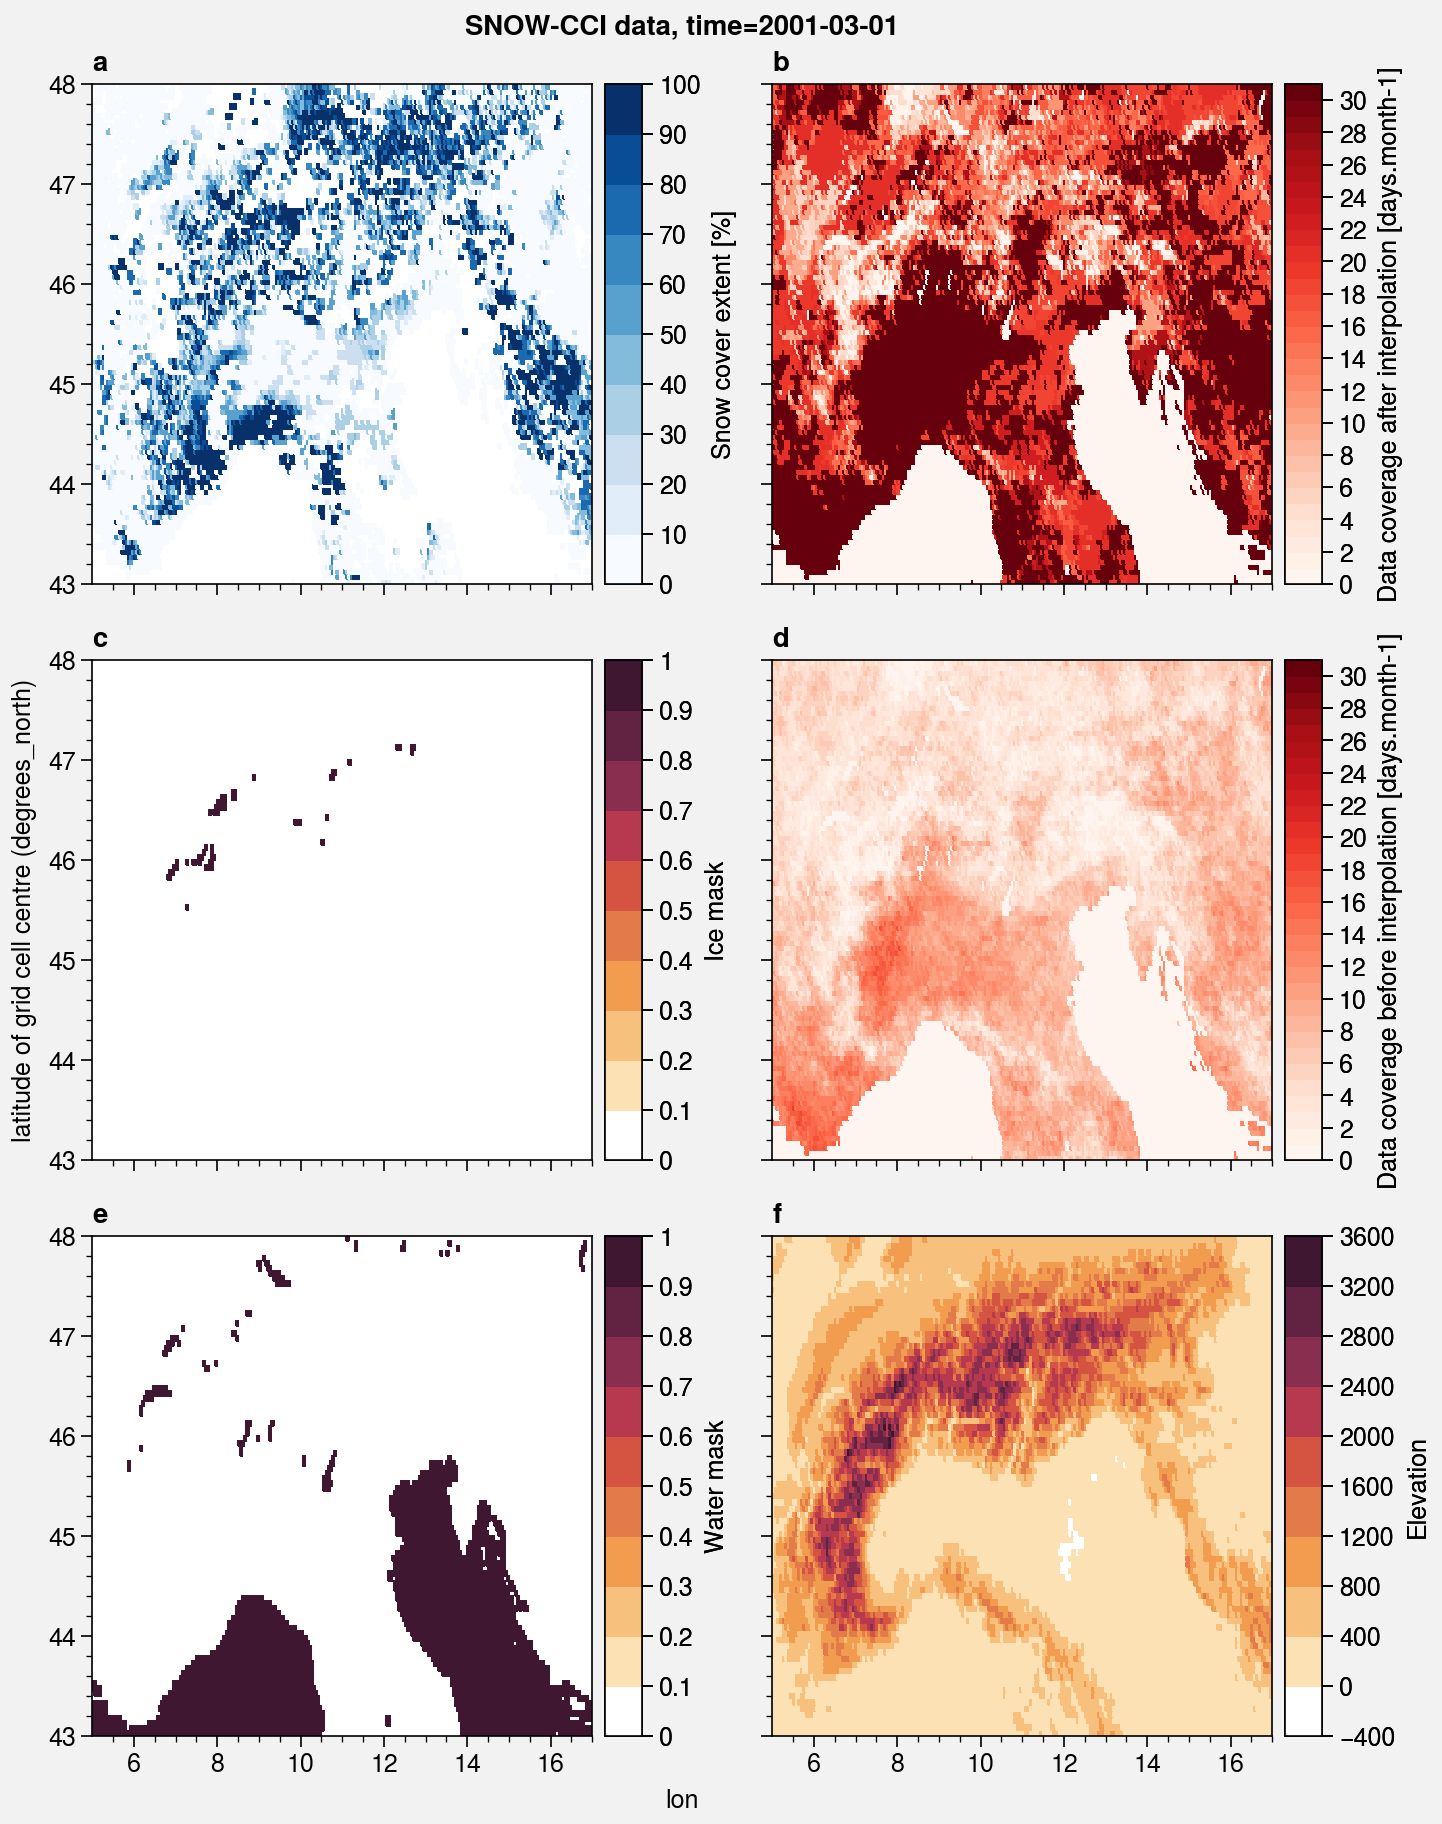

In [8]:
fig,axs = plot.subplots(nrows=3, ncols=2)
axs[0,0].pcolormesh(ds_alps_check.scfg_interp, levels=levels, colorbar='r', cmap=cmap, colorbar_kw={'label': 'Snow cover extent [%]'})
axs[0,1].pcolormesh(ds_alps_check.coverage_interp, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage after interpolation [days.month-1]'})
axs[1,0].pcolormesh(ds_alps_check.mask_ice, colorbar='r',colorbar_kw={'label': 'Ice mask'})
axs[1,1].pcolormesh(ds_alps_check.coverage, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage before interpolation [days.month-1]'})
axs[2,0].pcolormesh(ds_alps_check.mask_water, colorbar='r',colorbar_kw={'label': 'Water mask'})
axs[2,1].pcolormesh(elevation, colorbar='r',colorbar_kw={'label': 'Elevation'})
axs.format(
    suptitle='SNOW-CCI data, time='+time_extract,
    abc=True
)

In [9]:
dsi_topo = ds_topo.interp(lat=ds_alps.lat, lon=ds_alps.lon)

In [10]:
dsi_topo_check=dsi_topo.interp(lat=ds_topo.lat,lon=ds_topo.lon)

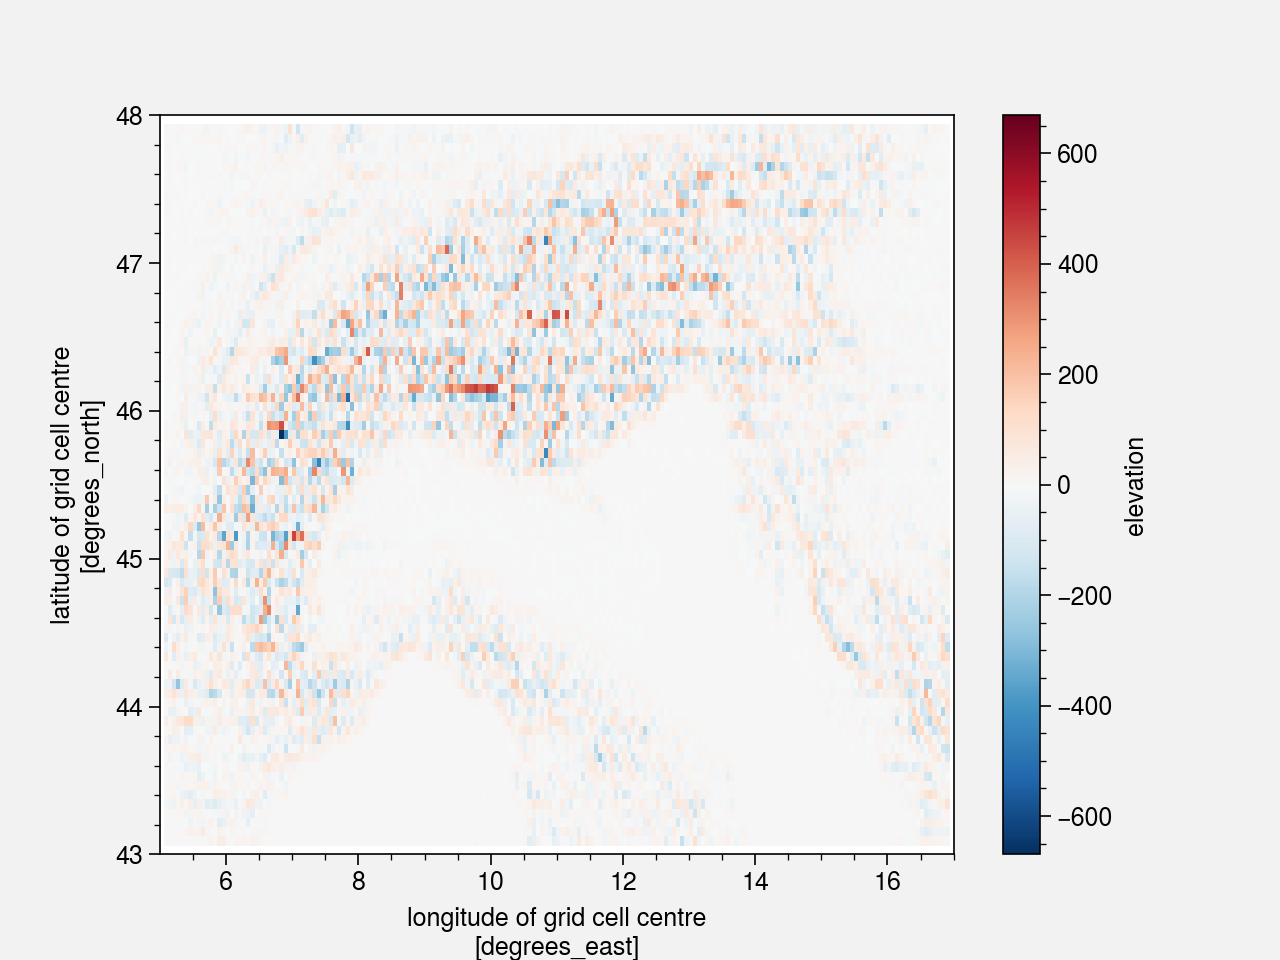

In [11]:
# Errors related to the interpolation applied two times
check=dsi_topo_check.elevation-ds_topo.elevation
check.plot()

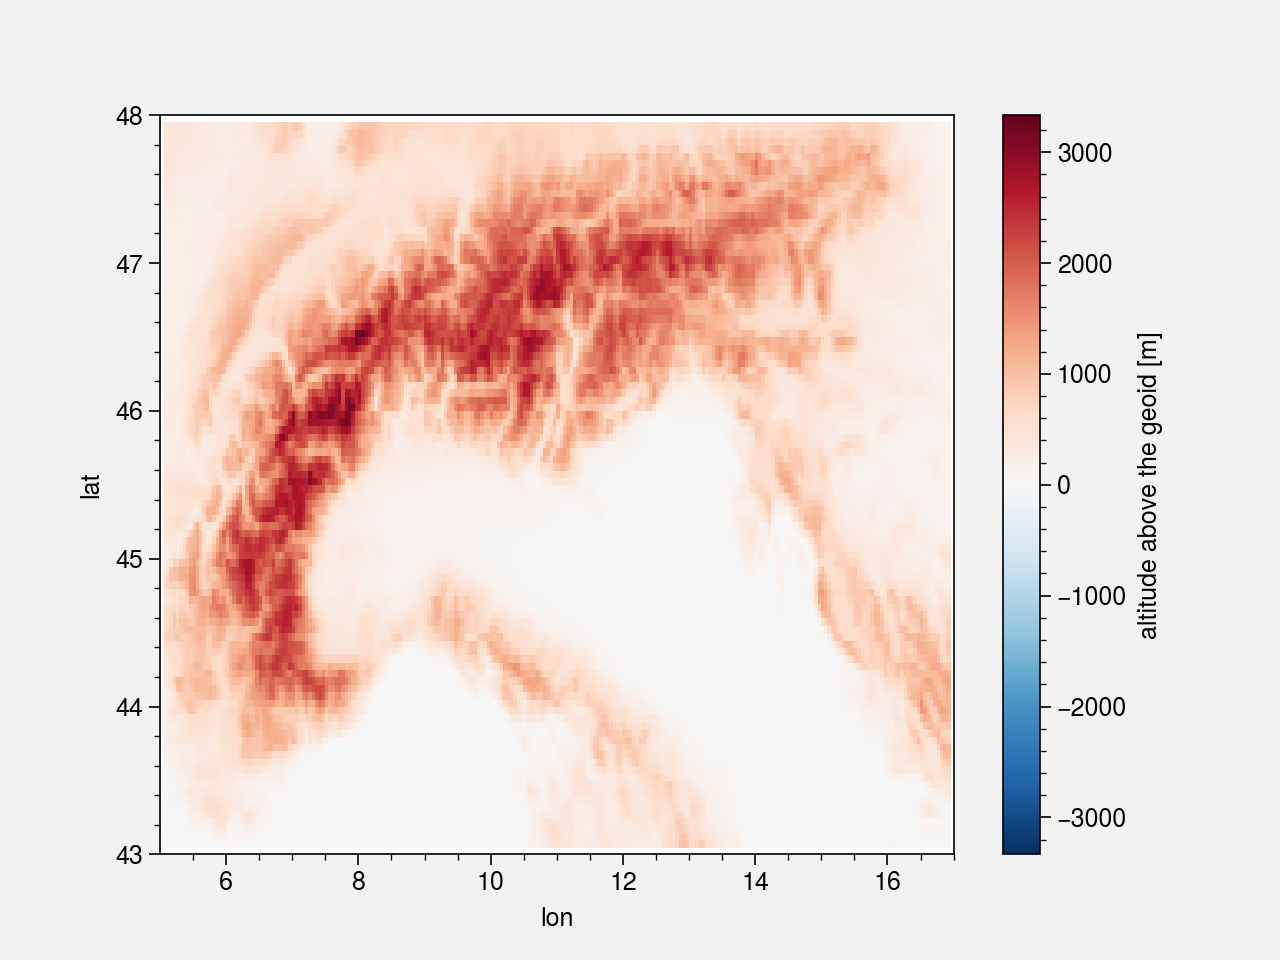

In [12]:
dsi_topo.elevation.plot()

In [13]:
# Testing 3D plots (Could be interesting for analysis on elevation bands)

In [14]:
delta=0.05
latlim_short,lonlim_short=slice(44+delta,48-delta), slice(5+delta,17-delta)

In [15]:
x,y = np.meshgrid(dsi_topo.lon.sel(lon=lonlim_short),dsi_topo.lat.sel(lat=latlim_short))

In [16]:
dsi_topo_short=dsi_topo.elevation.sel(lon=lonlim_short,lat=latlim_short)
x.shape, y.shape, dsi_topo_short.shape

((78, 238), (78, 238), (78, 238))

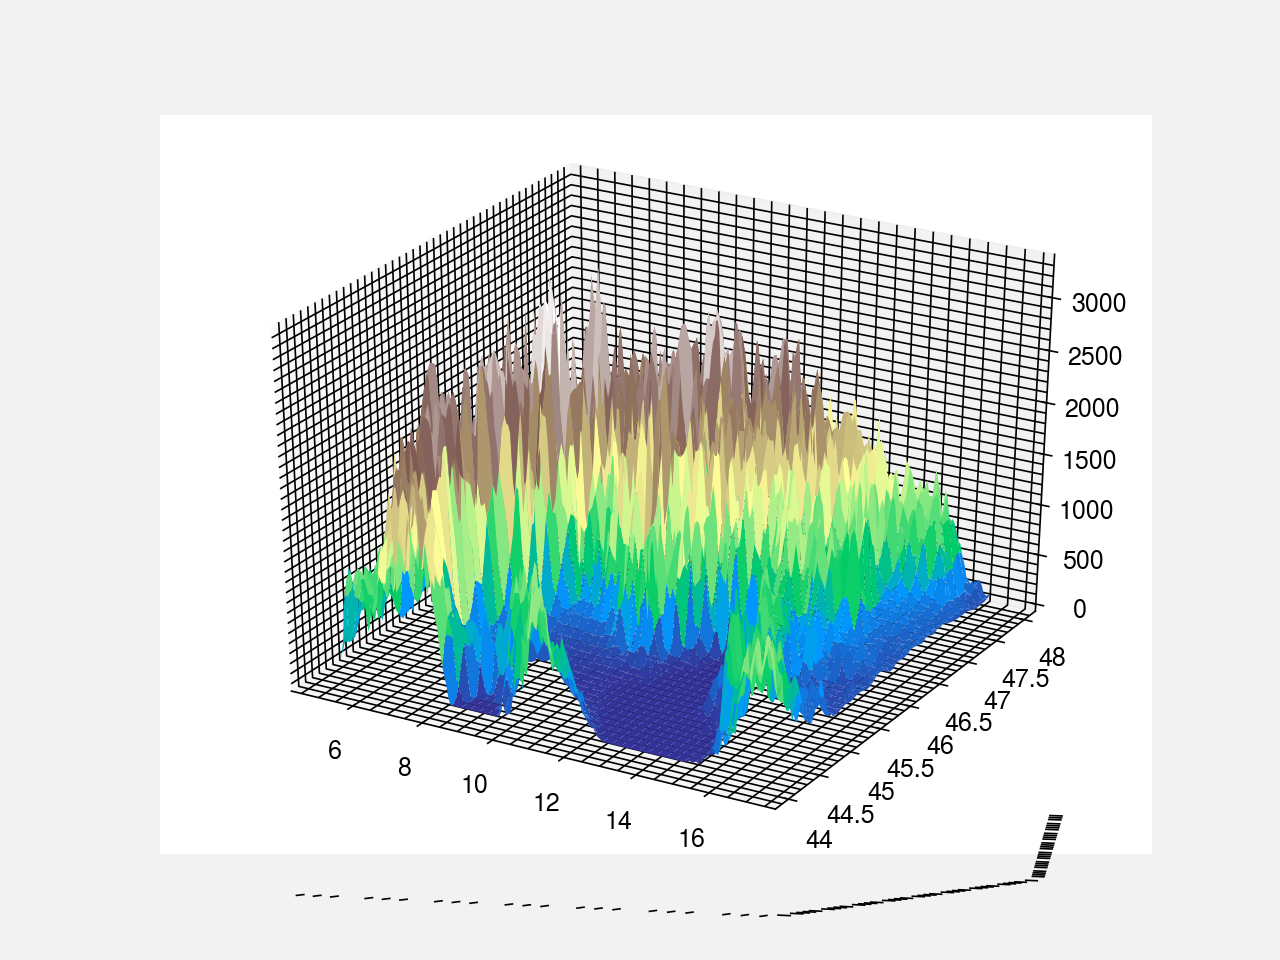

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,dsi_topo_short,cmap='terrain')

In [18]:
# Moving plot (Could be interesting for visualisation)
# https://jackmckew.dev/3d-terrain-in-python.html
#terrain_cmap = plt.cm.get_cmap('terrain')
#def matplotlib_to_plotly(cmap, pl_entries):
#    h = 1.0/(pl_entries-1)
#    pl_colorscale = []
#
#    for k in range(pl_entries):
#        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
#        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
#
#    return pl_colorscale
#
#terrain = matplotlib_to_plotly(terrain_cmap, 255)

In [19]:
#import plotly
#import plotly.graph_objects as go
#plotly.offline.init_notebook_mode(connected=True)
#
#fig = go.Figure(data=[go.Surface(colorscale=terrain,z=dsi_topo_short)])
#
#fig.update_layout(title='Random 3D Terrain')
#
# Note that include_plotlyjs is used as cdn so that the static site generator can read it and present it on the browser. This is not typically required.
#html = plotly.offline.plot(fig, filename='3d-terrain-plotly.html',include_plotlyjs='cdn')

In [20]:
#from IPython.core.display import HTML
#HTML(html)

***Snow cover duration***

In [39]:
# Parameters to compute snow cover duration
scf_threshold=0.1
min_available_values=15
min_available_values2=20 # Second value for testing/comparison

In [147]:
# Defining the time for the monthly data
months_per_year=12
time_nbdays = pd.date_range(start=str(first_year)+'-01-01',end=str(last_year+1)+'-01-01',freq='M')
reference_time = pd.Timestamp(str(first_year)+'-01-01')

In [187]:
# Initialise 12 month per year nbdays array
path_nbdays = Path(save_data+'/Alpine_snow_nbdays.nc')
if path.is_file():
    print(f'The file {path} already exists')
else:
    ds_nbdays = xr.Dataset({
        'nbdays': xr.DataArray(
            data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
            dims=["lat", "lon", "time"],
            coords=dict(
                lon=(["lon"], ds_alps.lon),
                lat=(["lat"], ds_alps.lat),
                time=time_nbdays,
                reference_time=reference_time,
            ),
            name='nbdays',
            attrs=dict(
                description="snow cover duration, minimum available value="+str(min_available_values),
                units="days.month-1",
            ),
            ),
        'nbdays2': xr.DataArray(
            data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
            dims=["lat", "lon", "time"],
            coords=dict(
                lon=(["lon"], ds_alps.lon),
                lat=(["lat"], ds_alps.lat),
                time=time_nbdays,
                reference_time=reference_time,
            ),
            name='nbdays',
            attrs=dict(
                description="snow cover duration, minimum available value="+str(min_available_values2),
                units="days.month-1",
            ),
            ),
        'nbdays_filled': xr.DataArray(
            data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
            dims=["lat", "lon", "time"],
            coords=dict(
                lon=(["lon"], ds_alps.lon),
                lat=(["lat"], ds_alps.lat),
                time=time_nbdays,
                reference_time=reference_time,
            ),
            name='nbdays_filled',
            attrs=dict(
                description="snow cover duration, monthly filled",
                units="days.month-1",
            ),
            )
        },
        attrs = {'documentation': 'Computing snow cover duration from CCI_SNOW snow cover fraction.\r'+
                 'Snow cover fraction threshold:'+str(scf_threshold*100)+'%.\r'+
                 'The data is monthly extrapolated in nbdays_filled when more than '+str(min_available_values)+' days of data is available'}
    )    

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow.nc already exists


In [191]:
# nbdays calculation
path_nbdays = Path(save_data+'/Alpine_snow_nbdays.nc')
if path.is_file():
    print(f'The file {path} already exists')
    ds_nbdays = xr.open_mfdataset(save_data+'/Alpine_snow_nbdays.nc', parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    for iyear, year in enumerate(range(first_year, last_year+1, 1)):
        for imonth in range(1,months_per_year+1,1):
            numday_month=cal.monthrange(year, imonth)[1]
            print('year='+str(year)+', month='+str(imonth)+', number of days='+str(numday_month))
            if (year==1994 and (imonth==10 or imonth==11 or imonth==12)) or (year==1995 and imonth==1):
                print('no data for this period, we let the np.nan in the array')
            else:
                print('computing nbdays')
                ds_tmp=ds_alps.sel(time=str(year)+'-'+str(imonth))
                binary_tmp=xr.where(ds_tmp.scfg_interp > scf_threshold, 1., 0.)
                binary=xr.where(xr.ufuncs.isnan(ds_tmp.scfg_interp), np.nan, binary_tmp)
                xnbdays=binary.sum(dim='time',skipna=True,min_count=min_available_values)
                xnbdays2=binary.sum(dim='time',skipna=True,min_count=min_available_values2)
                cov=ds_alps.coverage_interp.sel(time=str(year)+'-'+str(imonth)+'-01')
                xnbdays_filled=(xnbdays/cov)*numday_month
                ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays_filled[:,:,0]=xnbdays_filled
                ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays[:,:,0]=xnbdays
                ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays2[:,:,0]=xnbdays2
    ds_nbdays.to_netcdf(save_data+'/Alpine_snow_nbdays.nc')

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow.nc already exists


In [192]:
# Check plot for one specific date
time_check='2018-04'
#ds_alps_check=ds_alps.sel(time=time_extract)
levels_nbdays=plot.arange(0,31,1)
levels_elev=plot.arange(0,1000,1000)
cmap='winter_r'

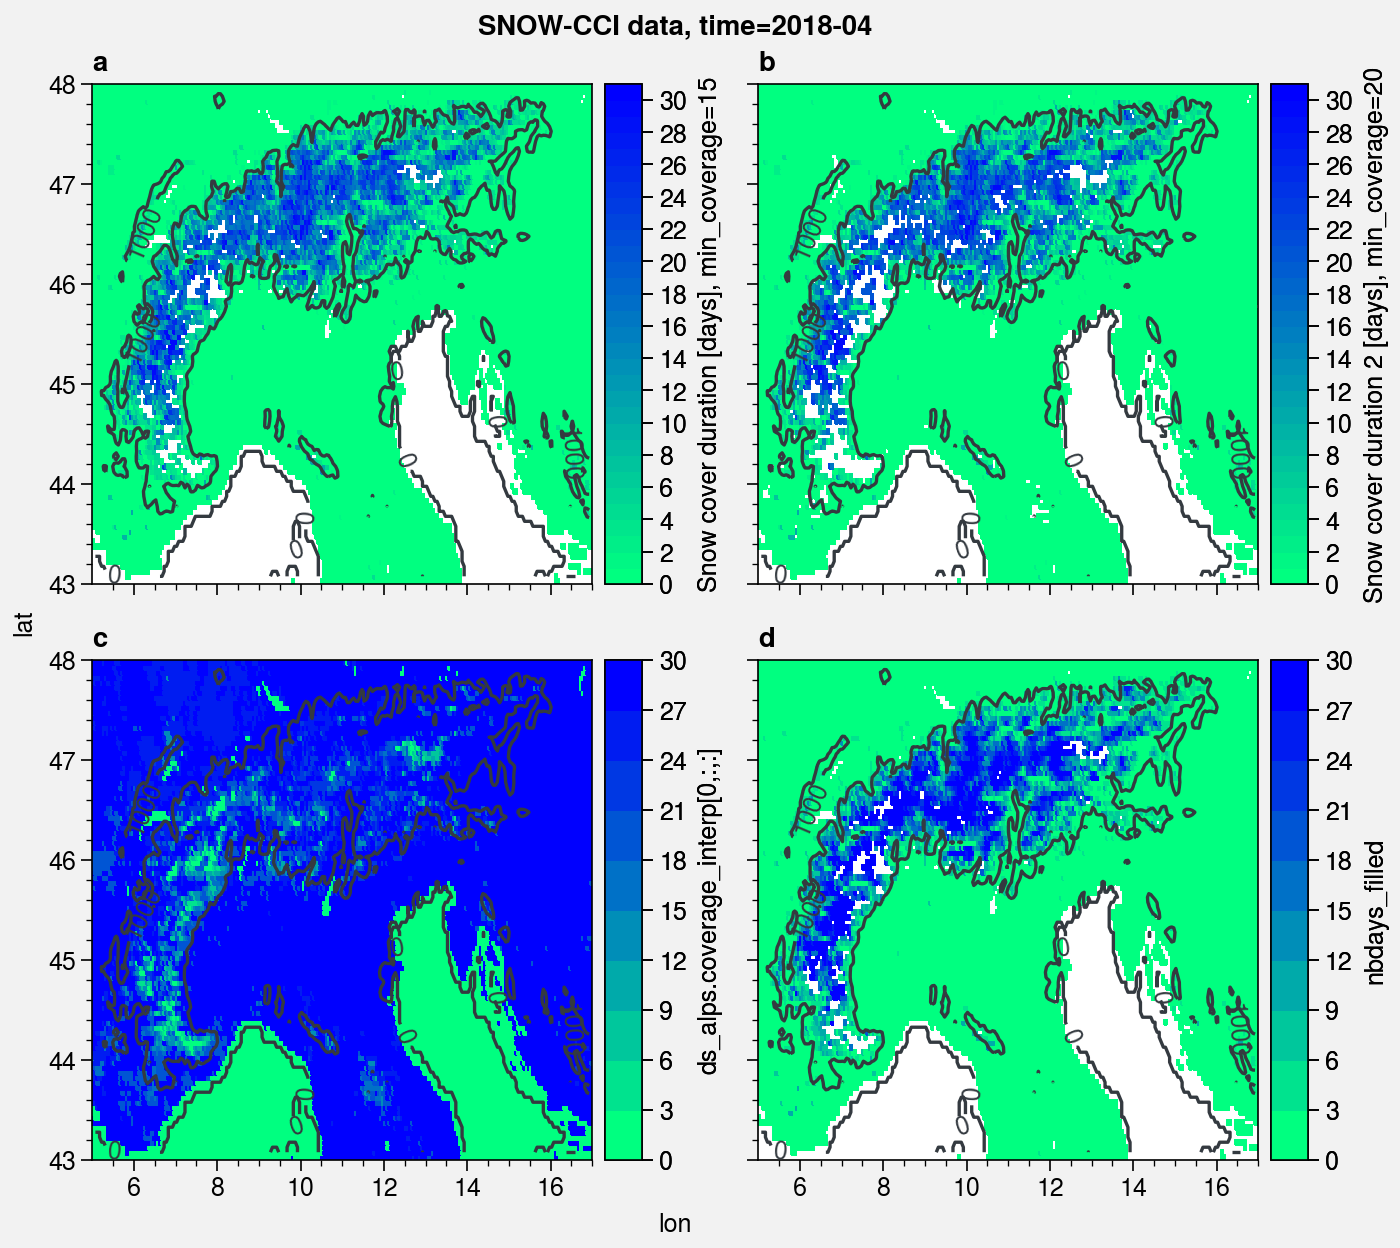

In [193]:
fig,axs = plot.subplots(nrows=2, ncols=2)
axs[0,0].pcolormesh(ds_nbdays.nbdays.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', colorbar_kw={'label': 'Snow cover duration [days], min_coverage='+str(min_available_values)})
axs[0,0].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[0,1].pcolormesh(ds_nbdays.nbdays2.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', colorbar_kw={'label': 'Snow cover duration 2 [days], min_coverage='+str(min_available_values2)})
axs[0,1].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[1,0].pcolormesh(ds_alps.coverage_interp.sel(time=time_check)[0,:,:], cmap=cmap, colorbar='r', colorbar_kw={'label': 'ds_alps.coverage_interp[0,:,:]'})
axs[1,0].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[1,1].pcolormesh(ds_nbdays.nbdays_filled.sel(time=time_check)[:,:,0], cmap=cmap, colorbar='r', colorbar_kw={'label': 'nbdays_filled'})
axs[1,1].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)

axs.format(
    suptitle='SNOW-CCI data, time='+time_check,
    abc=True
)

***Compute monthly trends***

In [198]:
# check one local trend
lon_loc=6.4; lat_loc=45.0
location_name='Col du Lautaret'
nbdays_loc=ds_nbdays.nbdays.sel(lon=lon_loc, lat=lat_loc, method="nearest")

In [199]:
# Monthly arrays and computing mean
monthly_nbdays_loc=np.empty(shape=(int(nbdays_loc.shape[0]/months_per_year),months_per_year), dtype=float)
for imonth in range(0,months_per_year,1):
    monthly_nbdays_loc[:,imonth]=nbdays_loc.sel(time=ds_nbdays.time.dt.month.isin([imonth+1]))
monthly_mean_nbdays_loc=np.nanmean(monthly_nbdays_loc,axis=0)

In [200]:
# Computing trends
slope_nbdays_loc=np.full(months_per_year,np.nan)
pvalue_nbdays_loc=np.full(months_per_year,np.nan)
intercept_nbdays_loc=np.full(months_per_year,np.nan)
monthly_nbdays_loc_nonan=monthly_nbdays_loc
for imonth in range(months_per_year):
    monthly_nbdays_loc_nonan[:,imonth][np.isnan(monthly_nbdays_loc_nonan[:,imonth])]=monthly_mean_nbdays_loc[imonth]
    linregress_nbdays_loc = stats.linregress(range(monthly_nbdays_loc.shape[0]), monthly_nbdays_loc_nonan[0:,imonth])
    slope_nbdays_loc[imonth] = linregress_nbdays_loc.slope
    intercept_nbdays_loc[imonth] = linregress_nbdays_loc.intercept
    pvalue_nbdays_loc[imonth] = linregress_nbdays_loc.pvalue

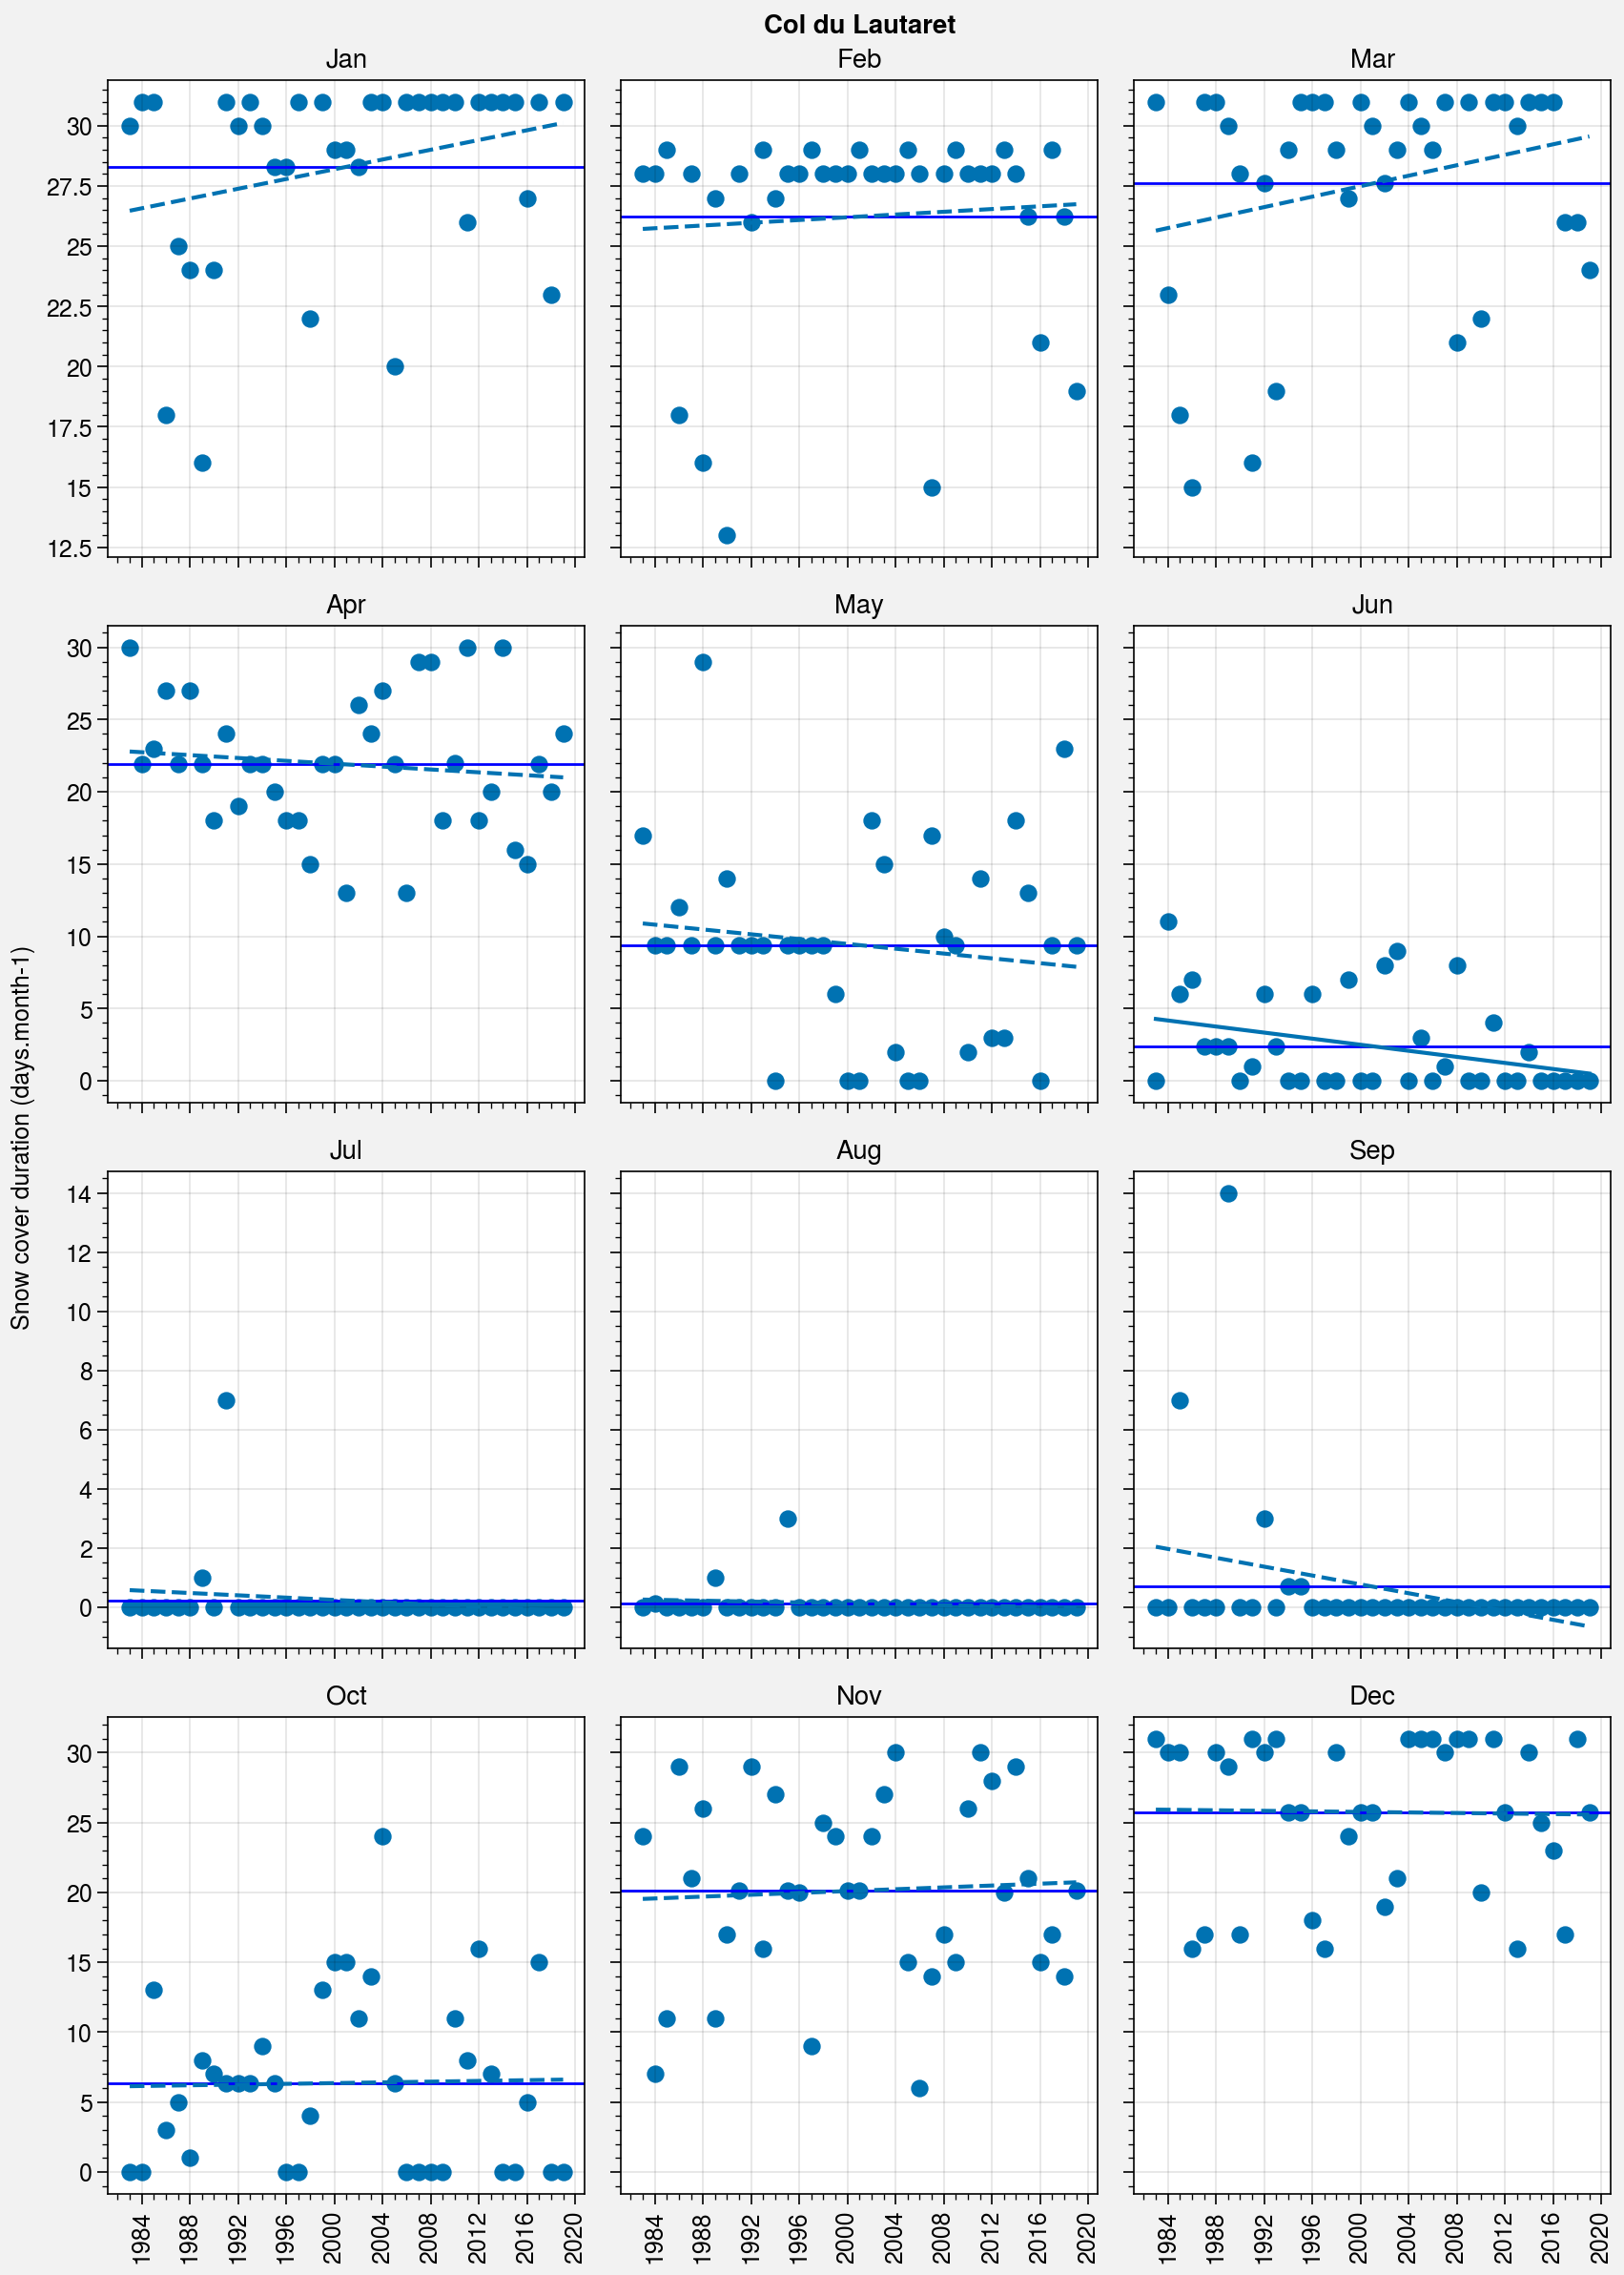

In [201]:
# Plot local timeseries and trends for all the months
fig, axs = plot.subplots(nrows=4, ncols=3)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year_time = pd.date_range(start=str(first_year),end=str(last_year+1),freq='Y')
index=np.arange(0,year_time.shape[0])
for i, ax in enumerate(axs):
    m = ax.axhline(monthly_mean_nbdays_loc[i], color='blue', linewidth=1)  # monthly mean
    m = ax.scatter(year_time,monthly_nbdays_loc[:,i])
    if pvalue_nbdays_loc[i]<0.05:
        signif='solid'
    else:
        signif='dashed'
    m = ax.plot(year_time,intercept_nbdays_loc[i]+slope_nbdays_loc[i]*index,linestyle=signif)
    ax.format(title=months[i])
axs.format(suptitle=location_name, ylabel='Snow cover duration (days.month-1)')